In [23]:
import xarray as xr
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# load data and perform clustering

In [28]:
shp = gpd.read_file('HCDN_nhru_final_671.buff_fix_holes.CAMELSandTDX_areabias_fix.simp.001.level1.gpkg')
lat = shp['lat_cen'].values
lon = shp['lon_cen'].values
shp.head()

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,Source,...,RawCAMELSarea,RawTDXarea,HSTDXarea,MHTDXarea,RawCAMELSbias,RawTDXbias,HSTDXbias,MHTDXbias,final_bias,geometry
0,1013500,0.0,-68.56551,47.01169,2.303988e+09,277.493490,None,None,647993,RawTDX,...,2303.988087,2246.946668,2246.628415,2246.132802,0.022767,-0.002554,-0.002695,-0.002915,0.002554,"POLYGON ((-68.84001 46.73746, -68.84200 46.737..."
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,HSTDX,...,620.387273,615.173865,586.427404,586.602450,0.081568,0.072479,0.022363,0.022668,0.022363,"POLYGON ((-68.13006 44.64717, -68.13461 44.637..."
2,1030500,0.0,-68.14985,45.80527,3.676155e+09,174.433896,None,None,662248,RawCAMELS,...,3676.154745,3654.475429,3653.788946,3653.845830,-0.000004,-0.005901,-0.006088,-0.006073,0.000004,"POLYGON ((-68.35800 45.67903, -68.36663 45.678..."
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,RawCAMELS,...,766.544703,775.632787,772.001421,772.168545,-0.003258,0.008560,0.003838,0.004055,0.003258,"POLYGON ((-69.67647 45.14558, -69.67380 45.151..."
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,RawCAMELS,...,904.956194,914.491471,914.237495,913.814091,-0.004558,0.005931,0.005651,0.005185,0.004558,"POLYGON ((-70.10847 45.21669, -70.10609 45.213..."


In [25]:
file = './output/climate_indice_remapped_Grid_climate_indices.nc'
ds = xr.open_dataset(file).isel(time=0)
ds

<xarray.Dataset>
Dimensions:                   (ID: 627)
Coordinates:
    time                      datetime64[ns] 2000-01-01
  * ID                        (ID) float64 1.0 2.0 3.0 4.0 ... 625.0 626.0 627.0
Data variables:
    latitude                  (ID) float64 ...
    longitude                 (ID) float64 ...
    aridity_Im                (ID) float32 ...
    seasonalityOfAridity_Imr  (ID) float32 ...
    annualSnowFraction_fs     (ID) float32 ...
Attributes:
    Conventions:    CF-1.6
    License:        GPLv3+; Originla license: No license from original file i...
    History:        Created Sat Mar  9 20:46:34 2024by EASYMORE nc_remapper; ...
    easymore_hash:  b9206412688377780325a26440a0caa9030b1b809f66b80318ead9ced...
    Source:         Remapped by EASYMORE nc_remapper from original file: Grid...

In [32]:
aridity_Im = ds['aridity_Im'].values
seasonalityOfAridity_Imr = ds['seasonalityOfAridity_Imr'].values
annualSnowFraction_fs = ds['annualSnowFraction_fs'].values

datain = np.vstack([aridity_Im, seasonalityOfAridity_Imr, annualSnowFraction_fs]).T
# datain = annualSnowFraction_fs[:,np.newaxis]

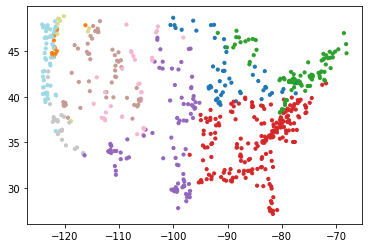

In [36]:
# clusters

index = ~np.isnan(np.sum(datain, axis=1))

# Creating a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the data to standardize it
datain_scaled = scaler.fit_transform(datain[index])

# Number of clusters
n_clusters = 10

# Initializing KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Fitting KMeans on the data
kmeans.fit(datain_scaled)

# Getting the cluster labels for each data point
labels = kmeans.labels_

# Optionally, you can also get the coordinates of cluster centers if needed
cluster_centers = kmeans.cluster_centers_

# print("Cluster labels for each data point:", labels)
# print("Coordinates of cluster centers:", cluster_centers)

plt.scatter(lon[index], lat[index], 10, labels, cmap='tab20')
plt.show()

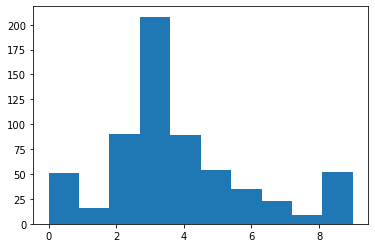

In [22]:
plt.hist(labels)
plt.show()

# save cluster results

In [19]:
df_out = shp[['hru_id', 'lat_cen', 'lon_cen', 'AREA', 'elev_mean']]
df_out['aridity_Im'] = aridity_Im
df_out['seasonalityOfAridity_Imr'] = seasonalityOfAridity_Imr
df_out['annualSnowFraction_fs'] = annualSnowFraction_fs
df_out['clusters'] = labels
df_out.to_csv('CAMELS_level1_627_clusters.csv', index=False)

/glade/derecho/scratch/guoqiang/tmp/ipykernel_63254/1553701507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['aridity_Im'] = aridity_Im
/glade/derecho/scratch/guoqiang/tmp/ipykernel_63254/1553701507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['seasonalityOfAridity_Imr'] = seasonalityOfAridity_Imr
/glade/derecho/scratch/guoqiang/tmp/ipykernel_63254/1553701507.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

# How to decide cluster numbers
Not used

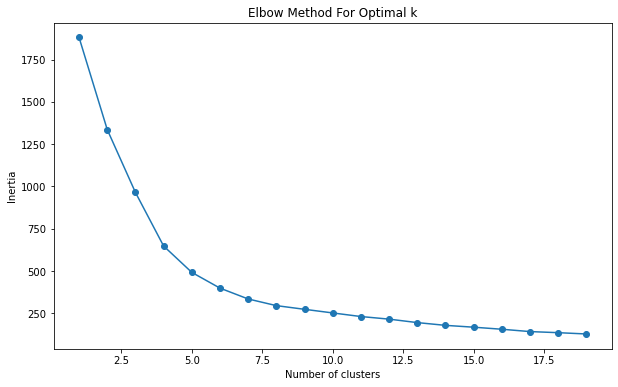

In [20]:
# Use the Elbow Method to find the optimal number of clusters
# maybe 5 or 6 where the gradient is not so sharp

inertia = []
K_range = range(1, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(datain_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()